In [2]:
%pip install ccxt
%pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.7 MB 1.9 MB/s eta 0:00:02
   ------------- -------------------------- 0.9/2.7 MB 11.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.5/2.7 MB 12.0 MB/s eta 0:00:01
   ------------------------------------ --- 2.5/2.7 MB 14.3 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 14.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import h5py
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

print(ccxt.exchanges)
from math import sqrt

exchange = ccxt.binance()

['ace', 'alpaca', 'ascendex', 'bequant', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bingx', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'bybit', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinmate', 'coinone', 'coinsph', 'coinspot', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'exmo', 'fmfwio', 'gate', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'kraken', 'krakenfutures', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'lbank2', 'luno', 'lykke', 'mercado', 'mexc', 'mexc3', 'ndax', 'novadax', 'oceanex', 'okcoin', 'okex', 'okex5', 'okx', 'paymium'

In [4]:
ticker = exchange.fetch_ticker("BTC/USDT")

current_price = ticker["ask"]

print(f"The current price of BTC is {current_price} USDT")

The current price of BTC is 67038.0 USDT


OHLC Data of last 24 hours

In [ ]:
yesterday_time = (
    int((datetime.utcnow() - timedelta(hours=24)).timestamp()) * 1000
)  # time 24 hours ago in milliseconds
since_time = (
    int((datetime.utcnow() - timedelta(minutes=440)).timestamp()) * 1000
)  # time since 1000 minutes from 24 hours ago in milliseconds

OHLC = pd.DataFrame(
    exchange.fetch_ohlcv(
        symbol="BTC/USDT",
        timeframe="1m",
        since=yesterday_time,
        limit=1000,  # max datapoints per call
    ),
    columns=["Time", "Open", "High", "Low", "Close", "Volume"],
)
OHLC_data_since = pd.DataFrame(
    exchange.fetch_ohlcv(
        symbol="BTC/USDT",
        timeframe="1m",
        since=since_time,
    ),
    columns=["Time", "Open", "High", "Low", "Close", "Volume"],
)

combined_OHLC = pd.concat([OHLC, OHLC_data_since], ignore_index=True)


combined_OHLC["Time"] = [
    datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
]
combined_OHLC.set_index("Time", inplace=True)

combined_OHLC

,Open,High,Low,Close,Volume
Time,,,,,
2023-10-22 23:27:00,30379.28,30396.78,30379.27,30390.82,23.24136
2023-10-22 23:28:00,30390.82,30418.83,30381.55,30412.75,64.70937
2023-10-22 23:29:00,30412.75,30438.41,30412.74,30429.00,61.22363
2023-10-22 23:30:00,30429.01,30435.80,30379.73,30381.78,32.08511
2023-10-22 23:31:00,30381.78,30412.28,30381.77,30412.28,52.27914
...,...,...,...,...,...
2023-10-23 19:22:00,33024.63,33090.00,32944.48,33083.31,174.52429
2023-10-23 19:23:00,33087.55,33281.94,33080.49,33207.25,246.71409
2023-10-23 19:24:00,33207.25,33251.49,32769.60,33106.69,439.03029


Plotting

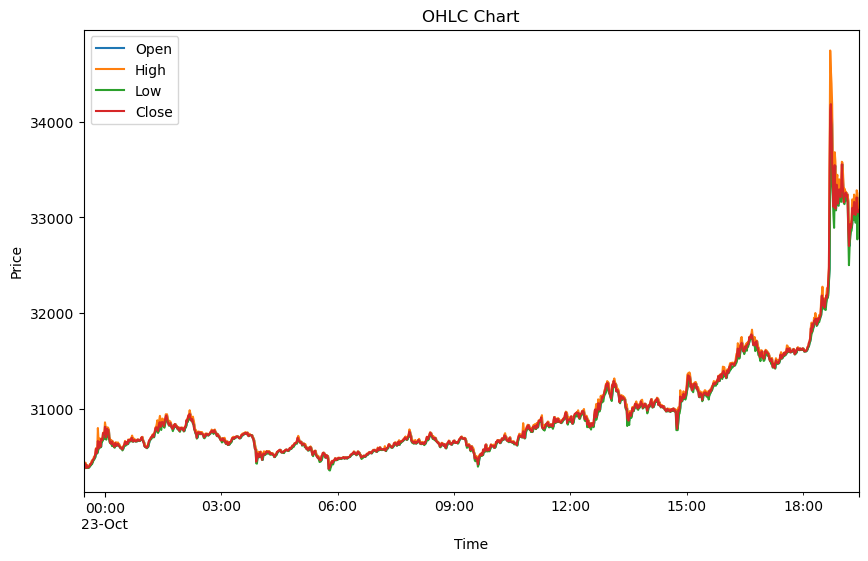

In [ ]:
combined_OHLC[["Open", "High", "Low", "Close"]].plot(style="-", figsize=(10, 6))

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("OHLC Chart")

plt.show()

OHLC Data Function

In [4]:
def get_OHLC_data(symbol, timeframe, time, limit=1000):

    since_time = datetime.utcnow() - timedelta(
        days=time
    )  # Length of time of data from the duration in days since today historically (could change to hours if wanted)

    combined_OHLC = pd.DataFrame(
        columns=["Time", "Open", "High", "Low", "Close", "Volume"]
    )

    while (
        since_time < datetime.utcnow()
    ):  # Looping in increments of limited 1000 calls until since_time reaches the current time
        current_since_time = int(since_time.timestamp()) * 1000

        OHLC_data = pd.DataFrame(
            exchange.fetch_ohlcv(
                symbol=symbol,
                timeframe=timeframe,
                since=current_since_time,
                limit=limit,
            ),
            columns=["Time", "Open", "High", "Low", "Close", "Volume"],
        )

        combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

        since_time += timedelta(
            minutes=(limit * int(timeframe[:-1]))
        )  # Increment by limit minutes

    combined_OHLC["Time"] = [
        datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
    ]
    combined_OHLC.set_index("Time", inplace=True)

    return combined_OHLC


# Example
symbol = "BTC/USDT"
timeframe = "1m"
time = 7  # Number of days since now

OHLC_data = get_OHLC_data(symbol, timeframe, time)
OHLC_data

C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\3210096221.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


KeyboardInterrupt: 

Data Quality Checker

In [ ]:
def check_data_quality(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Check for duplicates
    duplicates = df.duplicated().sum()
    duplicate_rows = None
    if duplicates != 0:
        duplicate_rows = df[df.duplicated()]
        duplicate_rows = (
            duplicate_rows.groupby(list(df)).apply(lambda x: tuple(x.index)).tolist()
        )

    return {
        "Missing Values": missing_values,
        "Duplicates": duplicate_rows,
    }

Data Check for OHLC Data

In [ ]:
quality_report = check_data_quality(OHLC_data)

print("Data Quality Report:")
for check, result in quality_report.items():
    print(f"\n{check}:\n{result}")

Data Quality Report:

Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Duplicates:
None


Test if function works for a basic data set with duplicates

In [ ]:
data = {
    "A": [1, 4, 1, 7, 10, 4, 1],
    "B": [2, 5, 2, 8, 11, 5, 2],
    "C": [3, 6, 3, 9, 12, 6, 3],
}

df = pd.DataFrame(data)

check_data_quality(df)

{'Missing Values': A    0
 B    0
 C    0
 dtype: int64,
 'Duplicates': [(2, 6), (5,)]}

Data pulling and compression for BTC

In [3]:
def get_all_OHLC_data(symbol, timeframe, limit=1000):
    combined_OHLC = pd.DataFrame(
        columns=["Time", "Open", "High", "Low", "Close", "Volume"]
    )

    while True:  # Continue fetching data until there is no more historical data
        if combined_OHLC.empty:
            since_time = datetime.utcnow() - timedelta(
                days=365 * 10
            )  # Start fetching data from 10 years ago
        else:
            since_time = datetime.fromtimestamp(
                combined_OHLC["Time"].iloc[-1] / 1000
            ) + timedelta(minutes=limit * int(timeframe[:-1]))

        current_since_time = int(since_time.timestamp()) * 1000

        OHLC_data = pd.DataFrame(
            exchange.fetch_ohlcv(
                symbol=symbol,
                timeframe=timeframe,
                since=current_since_time,
                limit=limit,
            ),
            columns=["Time", "Open", "High", "Low", "Close", "Volume"],
        )

        if len(OHLC_data) == 0:
            break  # Break the loop if no more data is available

        combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

    combined_OHLC["Time"] = [
        datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
    ]
    combined_OHLC.set_index("Time", inplace=True)

    return combined_OHLC


symbol = "BTC/USDT"
timeframe = "1h"

all_BTC_OHLC_data = get_all_OHLC_data(symbol, timeframe)
all_BTC_OHLC_data

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\3204819033.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


,Open,High,Low,Close,Volume
Time,,,,,
2017-08-17 00:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 01:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 02:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 03:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 04:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2024-05-23 20:00:00,67969.66,68000.00,67628.01,67852.00,1148.170330
2024-05-23 21:00:00,67851.99,67852.00,67657.55,67742.01,587.949890
2024-05-23 22:00:00,67742.01,68000.95,67634.15,67978.37,868.049520


In [ ]:
import h5py

symbol = "BTC/USDT"


def HDF5_converter(dataset, symbol):
    with h5py.File(
        "/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
        "w",
    ) as hdf:
        group = hdf.create_group(
            "Token_Warehouse"
        )  # Outermost group for all potential tokens
        symbol_group = group.create_group(
            f"{symbol}_group"
        )  # Subgroup for each token due to splitting datetime and OHLC data

        datetime_index_np = dataset.index.values.astype(
            h5py.opaque_dtype(dataset.index.dtype)
        )

        symbol_group.create_dataset(
            "datetime_index",
            data=datetime_index_np,
            compression="gzip",
            compression_opts=9,
        )

        symbol_group.create_dataset(
            "symbol", data=dataset, compression="gzip", compression_opts=9
        )


HDF5_converter(all_BTC_OHLC_data, symbol)

with h5py.File(
    "/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
    "r",
) as hdf:
    datetime_index = pd.to_datetime(
        hdf["Token_Warehouse"][f"{symbol}_group"]["datetime_index"][:]
    )

    data = hdf["Token_Warehouse"][f"{symbol}_group"]["symbol"][:]

    read_data = pd.DataFrame(
        data, index=datetime_index, columns=all_BTC_OHLC_data.columns
    )

    print("Read Data:")
    print(read_data)

Read Data:
                         Open      High       Low     Close       Volume
2017-08-17 00:00:00   4261.48   4313.62   4261.32   4308.83    47.181009
2017-08-17 01:00:00   4308.83   4328.69   4291.37   4315.32    23.234916
2017-08-17 02:00:00   4330.29   4345.45   4309.37   4324.35     7.229691
2017-08-17 03:00:00   4316.62   4349.99   4287.41   4349.99     4.443249
2017-08-17 04:00:00   4333.32   4377.85   4333.32   4360.69     0.972807
...                       ...       ...       ...       ...          ...
2023-11-20 21:00:00  37600.61  37649.44  37419.57  37452.34  1203.934890
2023-11-20 22:00:00  37452.33  37555.99  37399.99  37464.86   827.177770
2023-11-20 23:00:00  37464.86  37480.17  37388.00  37389.98   439.333590
2023-11-21 00:00:00  37389.99  37398.81  37316.00  37355.89   676.296470
2023-11-21 01:00:00  37355.90  37411.10  37322.00  37375.09   505.493320

[53914 rows x 5 columns]


Mutiple token data fetcher

In [6]:
def get_mutiple_all_OHLC_data(symbols, timeframe, limit=1000):
    all_combined_OHLC = {}

    for symbol in symbols:
        combined_OHLC = pd.DataFrame(
            columns=["Time", "Open", "High", "Low", "Close", "Volume"]
        )

        while True:  # Continue fetching data until there is no more historical data
            if combined_OHLC.empty:
                since_time = datetime.utcnow() - timedelta(
                    days=365 * 10
                )  # Start fetching data from 10 years ago
            else:
                since_time = datetime.fromtimestamp(
                    combined_OHLC["Time"].iloc[-1] / 1000
                ) + timedelta(minutes=limit * int(timeframe[:-1]))

            current_since_time = int(since_time.timestamp()) * 1000

            OHLC_data = pd.DataFrame(
                exchange.fetch_ohlcv(
                    symbol=symbol,
                    timeframe=timeframe,
                    since=current_since_time,
                    limit=limit,
                ),
                columns=["Time", "Open", "High", "Low", "Close", "Volume"],
            )

            if len(OHLC_data) == 0:
                break  # Break the loop if no more data is available

            combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

        combined_OHLC["Time"] = [
            datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
        ]
        combined_OHLC.set_index("Time", inplace=True)

        all_combined_OHLC[symbol] = combined_OHLC

    return all_combined_OHLC


# Example usage for fetching data for 10 coins
symbols = [
    "BTC/USDT",
    "ETH/USDT",
    "BNB/USDT",
    "XRP/USDT",
    "SOL/USDT",
    "ADA/USDT",
    "DOGE/USDT",
    "TRX/USDT",
    "LINK/USDT",
    "AVAX/USDT",
]
timeframe = "1m"

all_coins_data = get_mutiple_all_OHLC_data(symbols, timeframe)

C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\3977217044.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


KeyboardInterrupt: 

In [5]:
btc_data = all_coins_data["BTC/USDT"]

btc_data

NameError: name 'all_coins_data' is not defined

Multiple token converter

In [ ]:
def HDF5_converter(
    all_datasets,
    output_path="/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
):
    with h5py.File(output_path, "w") as hdf:
        group = hdf.create_group(
            "Token_Warehouse"
        )  # Outermost group for all potential tokens

        for symbol, dataset in all_datasets.items():
            symbol_group = group.create_group(
                f"{symbol}_group"
            )  # Subgroup for each token due to splitting datetime and OHLC data

            # Convert the datetime index to a NumPy array with opaque dtype
            datetime_index_np = dataset.index.values.astype(
                h5py.opaque_dtype(dataset.index.dtype)
            )

            # Save the datetime index as a separate dataset
            symbol_group.create_dataset(
                "datetime_index",
                data=datetime_index_np,
                compression="gzip",
                compression_opts=9,
            )

            # Save the main dataset
            symbol_group.create_dataset(
                "symbol", data=dataset.values, compression="gzip", compression_opts=9
            )


HDF5_converter(all_coins_data)

Basic Test

In [ ]:
with h5py.File(
    "/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
    "r",
) as hdf:
    print("File Structure:")
    print(list(hdf.keys()))

File Structure:
['Token_Warehouse']


In [ ]:
with h5py.File(
    '/Users/wsq/Desktop/Jupyter/minute-data-fetcher"/h5_compressed_data_warehouse.h5',
    "r",
) as hdf:
    if "Token_Warehouse" in hdf:
        print("'Token_Warehouse' group exists.")
        symbol_group = hdf["Token_Warehouse"]["BTC/USDT_group"]
        if "symbol" in symbol_group:
            print("'symbol' dataset exists.")
        else:
            print("'symbol' dataset does not exist.")
    else:
        print("'Token_Warehouse' group does not exist.")

'Token_Warehouse' group exists.
'symbol' dataset exists.


# Utilizing Token Warehouse for Pairs Trading Strategy

#### ETH and BTC

##### ETH and BTC Plot for Time Series of Minute Data

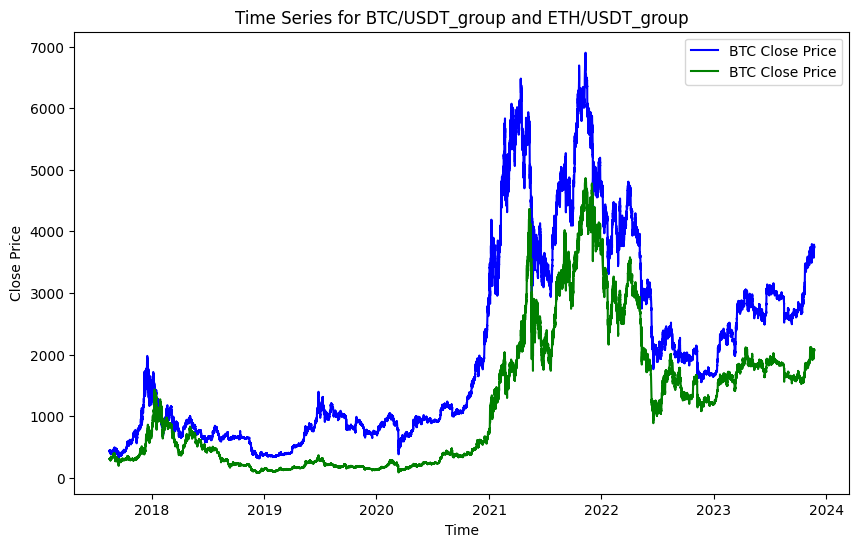

In [2]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

token_1 = "BTC/USDT_group"
token_2 = "ETH/USDT_group"

with h5py.File("h5_compressed_data_warehouse.h5", "r") as hdf:
    BTC_data = hdf[f"/Token_Warehouse/{token_1}"]
    ETH_data = hdf[f"/Token_Warehouse/{token_2}"]

    datetime_index_np = BTC_data["datetime_index"][:]

    BTC_symbol_data = BTC_data["symbol"][:]
    ETH_symbol_data = ETH_data["symbol"][:]

    # Convert the opaque dtype back to datetime
    datetime_index = pd.to_datetime(datetime_index_np, unit="ns")

    # Creating a DataFrame
    df1 = pd.DataFrame(
        BTC_symbol_data,
        index=datetime_index,
        columns=["Open", "High", "Low", "Close", "Volume"],
    )
    df2 = pd.DataFrame(
        ETH_symbol_data,
        index=datetime_index,
        columns=["Open", "High", "Low", "Close", "Volume"],
    )

    # Plotting the time series line graph
    plt.figure(figsize=(10, 6))
    plt.plot(
        df1.index, df1["Close"] / 10, label="BTC Close Price", color="blue"
    )  # Scaled BTC close prices down by a factor of 10 to make the relationship more evident
    plt.plot(df2.index, df2["Close"], label="BTC Close Price", color="green")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.title(f"Time Series for {token_1} and {token_2}")
    plt.legend()
    plt.show()

Function to make opening h5 easier

In [10]:
def process_h5_file_close_data(file_path, group_path):

    with h5py.File(file_path, "r") as hdf:
        # Access the necessary datasets
        datetime_index = hdf[f"{group_path}/datetime_index"][:]
        close_prices = hdf[f"{group_path}/symbol"][:, 3]

        # Create a DataFrame
        df = pd.DataFrame(
            close_prices,
            index=pd.to_datetime(datetime_index, unit="ns"),
            columns=["Close"],
        )

    return df


eth = process_h5_file_close_data(
    "h5_compressed_data_warehouse.h5", "Token_Warehouse/ETH/USDT_group"
)


btc = process_h5_file_close_data(
    "h5_compressed_data_warehouse.h5", "Token_Warehouse/BTC/USDT_group"
)
btc

,Close
2017-08-17 00:00:00,4261.48
2017-08-17 00:01:00,4261.48
2017-08-17 00:02:00,4280.56
2017-08-17 00:03:00,4261.48
2017-08-17 00:04:00,4261.48
...,...
2023-11-23 05:32:00,37507.92
2023-11-23 05:33:00,37501.10
2023-11-23 05:34:00,37486.00
2023-11-23 05:35:00,37460.02


Testing and Training data with a 20/80 split where training is the most recent data and further data processing

In [11]:
from sklearn.model_selection import train_test_split

btc_train, btc_test = train_test_split(btc, test_size=0.2, shuffle=False)

eth_train, eth_test = train_test_split(eth, test_size=0.2, shuffle=False)

eth_train_returns = eth_train["Close"] / eth_train["Close"].shift(1) * 100

eth_train_returns = np.log(eth_train_returns).dropna()

btc_train_returns = btc_train["Close"] / btc_train["Close"].shift(1) * 100

btc_train_returns = np.log(btc_train_returns).dropna()

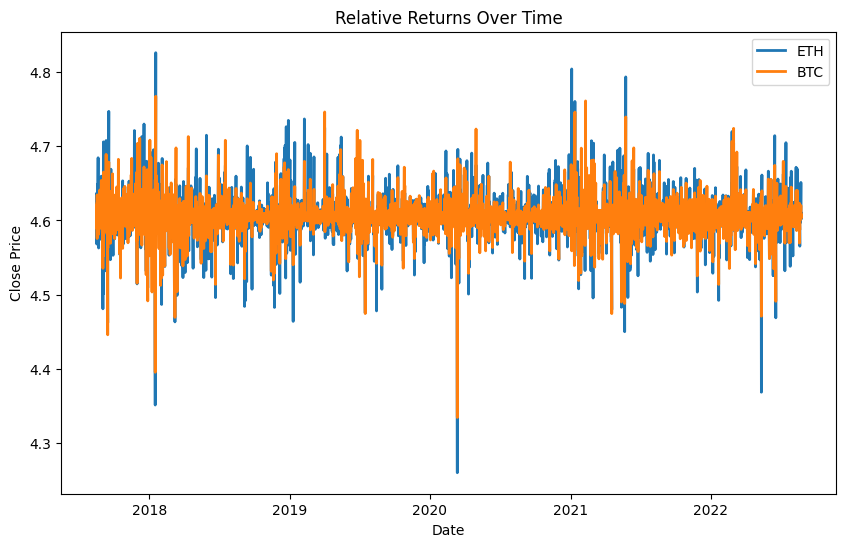

In [12]:
plt.figure(figsize=(10, 6))

# Plot ETH Close values
plt.plot(eth_train_returns.index, eth_train_returns.values, label="ETH", linewidth=2)
plt.plot(btc_train_returns.index, btc_train_returns.values, label="BTC", linewidth=2)

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Relative Returns Over Time")

# Add legend
plt.legend()

# Show the plot
plt.show()

Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

df_returns = pd.DataFrame({"ETH": eth_train_returns, "BTC": btc_train_returns})

x_train = df_returns[["BTC"]]
y_train = df_returns["ETH"]

model = LinearRegression()

model.fit(x_train, y_train)

model.score(x_train, y_train)  # R^2

coef = model.coef_[0]

intercept = model.intercept_

print(intercept)
print(coef)

errors = y_train - (coef * x_train["BTC"] + intercept)

0.8082721361871856
0.8244859926773564


Charting the errors

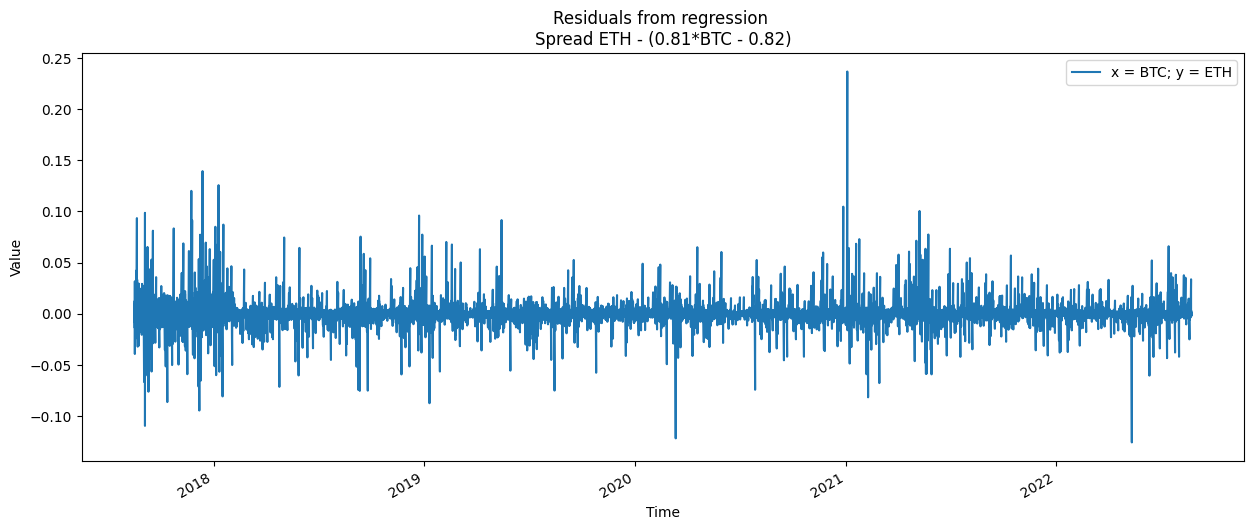

In [14]:
plt.figure(figsize=(15, 6))
errors.plot(label="x = BTC; y = ETH")
plt.title("Residuals from regression \nSpread ETH - (0.81*BTC - 0.82)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

Dickey Fuller test (Testing for unit root in AR model (Stationarity))

In [15]:
from statsmodels.tsa.stattools import adfuller


dftest = adfuller(errors, maxlag=1)
dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test Stat",
        "P-Val",
        "#Lags Used",
        "#Obs Used",
    ],
)
critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

print(
    f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
)

Dikey Fuller Results:
Test Stat    -9.344814e+02
P-Val         0.000000e+00
#Lags Used    1.000000e+00
#Obs Used     1.317597e+06
dtype: float64 

Dikey Fuller Critical Values:
1%    -3.430355
5%    -2.861542
10%   -2.566771
dtype: float64


###### This means that we reject the null at all significant values that the model is non-stationary

Z-Score and Signals starting with 1.2 and -1.2 Thresholds

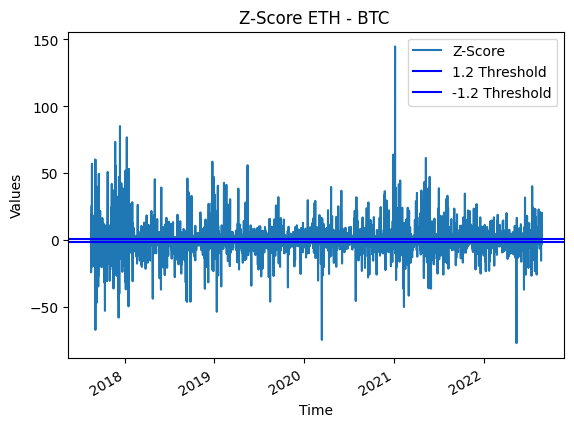

In [16]:
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)
zscore.plot(label="Z-Score")
plt.title("Z-Score ETH - BTC ")
plt.xlabel("Time")
plt.ylabel("Values")
plt.axhline(y=1.2, color="b", label="1.2 Threshold")
plt.axhline(y=-1.2, color="b", label="-1.2 Threshold")
plt.legend()
plt.show()

Backtest on training data

In [17]:
# Long the spread: short ETH, long BTC
# Short the spread: long ETH, short BTC


signal_entry = 1.2
signal_exit = 0


btest = pd.DataFrame()
btest["ETH"] = eth_train["Close"]
btest["BTC"] = btc_train["Close"]

btest = btest.iloc[1:]

btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

Backtest

In [18]:
spread_side = None
counter = -1
backtest_result = []
indicator = 0
for time, signals_stock in btest.iterrows():
    counter += 1
    eth_, btc_, short_sig, short_ex, long_sig, long_ex = signals_stock

    if spread_side == None:
        eth_return = 0
        btc_return = 0
        backtest_result.append([time, eth_return, btc_return, spread_side])

        if short_sig == True:
            spread_side = "short"
        elif long_sig == True:
            spread_side = "long"

    elif spread_side == "long":
        eth_return = btest["ETH"][counter] / btest["ETH"][counter - 1] - 1.0
        btc_return = btest["BTC"][counter] / btest["BTC"][counter - 1] - 1.0
        backtest_result.append([time, eth_return, -btc_return, spread_side])

        if long_ex == True:
            spread_side = None

    elif spread_side == "short":
        eth_return = btest["ETH"][counter] / btest["ETH"][counter - 1] - 1.0
        btc_return = btest["BTC"][counter] / btest["BTC"][counter - 1] - 1.0
        backtest_result.append([time, -eth_return, btc_return, spread_side])

        if short_ex == True:
            spread_side = None

backtest_result_train = backtest_result

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\2012128715.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eth_return = btest["ETH"][counter] / btest["ETH"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\2012128715.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_return = btest["BTC"][counter] / btest["BTC"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\2012128715.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

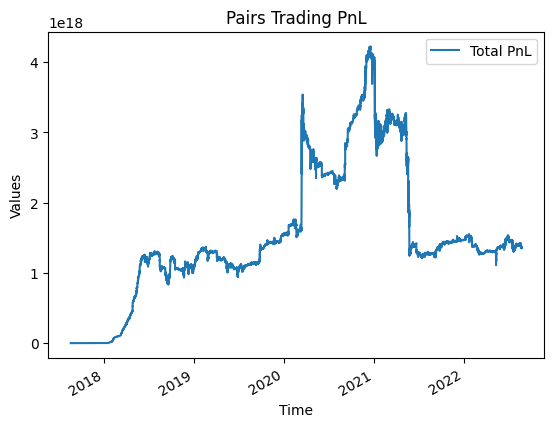

In [19]:
backtest_pd = pd.DataFrame(backtest_result)
backtest_pd.columns = ["Date", "ETH", "BTC", "Side"]
backtest_pd["ETH PnL"] = np.cumprod(backtest_pd["ETH"] + 1)
backtest_pd["BTC PnL"] = np.cumprod(backtest_pd["BTC"] + 1)
backtest_pd["Total PnL"] = (backtest_pd["BTC PnL"] + backtest_pd["ETH PnL"]) / 2
backtest_pd.index = backtest_pd["Date"]

total_return_train = backtest_pd[["Total PnL"]]
backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss")
plt.title("Pairs Trading PnL")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

### Backtest on Test Data

In [57]:
eth_test_returns = eth_test["Close"] / eth_test["Close"].shift(1) * 100

eth_test_returns = np.log(eth_test_returns).dropna()

btc_test_returns = btc_test["Close"] / btc_test["Close"].shift(1) * 100

btc_test_returns = np.log(btc_test_returns).dropna()


df_test_returns = pd.DataFrame({"ETH": eth_test_returns, "BTC": btc_test_returns})

x_test = df_test_returns[["BTC"]]
y_test = df_test_returns["ETH"]

errors_test = y_test - (coef * x_test["BTC"] + intercept)

spread = errors_test
zscore = (spread - np.mean(spread)) / np.std(spread)

In [60]:
signal_entry = 1.2
signal_exit = 0


btest = pd.DataFrame()
btest["ETH"] = eth_test["Close"]
btest["BTC"] = btc_test["Close"]

btest = btest.iloc[1:]

btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)


spread_side = None
counter = -1
backtest_result = []
indicator = 0
for time, signals_stock in btest.iterrows():
    counter += 1
    eth_, btc_, short_sig, short_ex, long_sig, long_ex = signals_stock

    if spread_side == None:
        eth_return = 0
        btc_return = 0
        backtest_result.append([time, eth_return, btc_return, spread_side])

        if short_sig == True:
            spread_side = "short"
        elif long_sig == True:
            spread_side = "long"

    elif spread_side == "long":
        eth_return = btest["ETH"][counter] / btest["ETH"][counter - 1] - 1.0
        btc_return = btest["BTC"][counter] / btest["BTC"][counter - 1] - 1.0
        backtest_result.append([time, eth_return, -btc_return, spread_side])

        if long_ex == True:
            spread_side = None

    elif spread_side == "short":
        eth_return = btest["ETH"][counter] / btest["ETH"][counter - 1] - 1.0
        btc_return = btest["BTC"][counter] / btest["BTC"][counter - 1] - 1.0
        backtest_result.append([time, -eth_return, btc_return, spread_side])

        if short_ex == True:
            spread_side = None

backtest_result

C:\Users\wsq\AppData\Local\Temp\ipykernel_47180\2763465535.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eth_return = btest["ETH"][counter] / btest["ETH"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_47180\2763465535.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_return = btest["BTC"][counter] / btest["BTC"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_47180\2763465535.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

[[Timestamp('2022-08-23 06:47:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:48:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:49:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:50:00'),
  -0.0008521437323896208,
  0.00042485708396611255,
  'long'],
 [Timestamp('2022-08-23 06:51:00'),
  -0.0008528705006410897,
  0.0008435290938048068,
  'long'],
 [Timestamp('2022-08-23 06:52:00'),
  0.0008785210938522248,
  -0.0008479850994229654,
  'long'],
 [Timestamp('2022-08-23 06:53:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:54:00'),
  0.0010751151243219015,
  -0.0008121705081692854,
  'short'],
 [Timestamp('2022-08-23 06:55:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:56:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:57:00'),
  0.0007828518173346177,
  -0.0003904938111869427,
  'short'],
 [Timestamp('2022-08-23 06:58:00'), 0, 0, None],
 [Timestamp('2022-08-23 06:59:00'), 0, 0, None],
 [Timestamp('2022-08-23 07:00:00'), 0, 0, None],
 [Timestamp('2022-08-23 07:01:00'), 0, 0, None],
 [Timestamp('2022

In [61]:
backtest_pd = pd.DataFrame(backtest_result)
backtest_pd.columns = ["Date", "ETH", "BTC", "Side"]
backtest_pd["ETH PnL"] = np.cumprod(backtest_pd["ETH"] + 1)
backtest_pd["BTC PnL"] = np.cumprod(backtest_pd["BTC"] + 1)
backtest_pd["Total PnL"] = (backtest_pd["BTC PnL"] + backtest_pd["ETH PnL"]) / 2
backtest_pd.index = backtest_pd["Date"]

backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss for Test Data")
plt.title("Pairs Trading PnL")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

backtest_pd

,Date,ETH,BTC,Side
0,2022-08-23 06:47:00,0.000000,0.000000,None
1,2022-08-23 06:48:00,0.000000,0.000000,None
2,2022-08-23 06:49:00,0.000000,0.000000,None
3,2022-08-23 06:50:00,-0.000852,0.000425,long
4,2022-08-23 06:51:00,-0.000853,0.000844,long
...,...,...,...,...
329394,2023-11-23 05:32:00,0.000000,0.000000,None
329395,2023-11-23 05:33:00,0.000000,0.000000,None
329396,2023-11-23 05:34:00,0.000000,0.000000,None
329397,2023-11-23 05:35:00,0.000000,0.000000,None


#### Generalizing the process 

In [20]:
def process_returns(data, value: str):
    """Process PD DF with Close values column to get log relative returns of Close values to return a new dataframe"""
    asset_returns = data[value] / data[value].shift(1) * 100

    asset_returns = np.log(asset_returns).dropna()

    return asset_returns


def regress_for_values(Y_coin_returns, X_coin_returns):
    """Linear Regression for"""
    df_returns = pd.DataFrame({"Y": Y_coin_returns, "X": X_coin_returns})

    x_train = df_returns[["X"]]
    y_train = df_returns["Y"]

    model = LinearRegression()

    model.fit(x_train, y_train)

    coef = model.coef_[0]

    intercept = model.intercept_

    errors = y_train - (coef * x_train["X"] + intercept)

    return errors


def regress_for_values_test(y_test_ret, x_test_ret, y_train_ret, x_train_ret):
    """Helper for getting errors of test data given training data"""
    df_returns = pd.DataFrame({"Y": y_train_ret, "X": x_train_ret})

    x_train = df_returns[["X"]]
    y_train = df_returns["Y"]

    model = LinearRegression()

    model.fit(x_train, y_train)

    coef = model.coef_[0]

    intercept = model.intercept_

    df_test_returns = pd.DataFrame({"Y": y_test_ret, "X": x_test_ret})

    x_test = df_test_returns[["X"]]
    y_test = df_test_returns["Y"]

    errors_test = y_test - (coef * x_test["X"] + intercept)

    return errors_test


def adfuller_test(errors, sig_lvl="1%"):
    """adfuller test to test wether or not their exists cointegration at the 1% level. True if test stat > 1% significance critical value"""
    dftest = adfuller(errors, maxlag=1)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Stat",
            "P-Val",
            "#Lags Used",
            "#Obs Used",
        ],
    )
    critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

    return dfoutput["Test Stat"] < critical_values[sig_lvl]


def backtest(errors, signal_entry, signal_exit, X_data, Y_data, value):
    """Backtesting Process"""
    spread = errors
    zscore = (spread - np.mean(spread)) / np.std(spread)

    btest = pd.DataFrame()
    btest["Y"] = Y_data[value]
    btest["X"] = X_data[value]

    btest = btest.iloc[1:]

    btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
    btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

    btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
    btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

    spread_side = None
    counter = -1
    backtest_result = []
    indicator = 0
    for time, signals_stock in btest.iterrows():
        counter += 1
        y_, x_, short_sig, short_ex, long_sig, long_ex = signals_stock

        if spread_side == None:
            y_return = 0
            x_return = 0
            backtest_result.append([time, y_return, x_return, spread_side])

            if short_sig == True:
                spread_side = "short"
            elif long_sig == True:
                spread_side = "long"

        elif spread_side == "long":
            y_return = btest["Y"][counter] / btest["Y"][counter - 1] - 1.0
            x_return = btest["X"][counter] / btest["X"][counter - 1] - 1.0
            backtest_result.append([time, y_return, -x_return, spread_side])

            if long_ex == True:
                spread_side = None

        elif spread_side == "short":
            y_return = btest["Y"][counter] / btest["Y"][counter - 1] - 1.0
            x_return = btest["X"][counter] / btest["X"][counter - 1] - 1.0
            backtest_result.append([time, -y_return, x_return, spread_side])

            if short_ex == True:
                spread_side = None

    return backtest_result


def show_PnL(backtest_result):
    """Showing PnL result"""
    backtest_pd = pd.DataFrame(backtest_result)
    backtest_pd.columns = ["Date", "Y", "X", "Side"]
    backtest_pd["Y PnL"] = np.cumprod(backtest_pd["Y"] + 1)
    backtest_pd["X PnL"] = np.cumprod(backtest_pd["X"] + 1)
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2
    backtest_pd.index = backtest_pd["Date"]

    backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss for Data")
    plt.title("Pairs Trading PnL")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()


# need to split into training and testing sets before this


def pair_trade_result(
    data_x_train,
    data_y_train,
    data_x_test,
    data_y_test,
    value="Close",
    signal_entry=1.2,
    signal_exit=0,
    sig_level="1%",
):
    """Full Function from start to finish"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    x_returns_test = process_returns(data_x_test, value)
    y_returns_test = process_returns(data_y_test, value)

    errors_train = regress_for_values(y_returns, x_returns)
    errors_test = regress_for_values_test(
        y_returns_test, x_returns_test, y_returns, x_returns
    )

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    results_test = backtest(
        errors_test, signal_entry, signal_exit, data_x_test, data_y_test, value
    )

    print("Training PnL")
    show_PnL(results_train)

    print("Test PnL")
    show_PnL(results_test)


def final_profit(data_x_train,data_y_train,value="Close",signal_entry=1.2,signal_exit=0,sig_level="1%",):
    """Get final profit given a signal entry value"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    errors_train = regress_for_values(y_returns, x_returns)

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    backtest_pd = pd.DataFrame(results_train)
    backtest_pd.columns = ["Date", "Y", "X", "Side"]
    backtest_pd["Y PnL"] = np.cumprod(backtest_pd["Y"] + 1)
    backtest_pd["X PnL"] = np.cumprod(backtest_pd["X"] + 1)
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2

    return backtest_pd["Total PnL"].iloc[-1]


def std_dev_returns(
    data_x_train,
    data_y_train,
    value="Close",
    signal_entry=1.2,
    signal_exit=0,
    sig_level="1%",
):
    """Get sharpe ratio given a signal entry value"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    errors_train = regress_for_values(y_returns, x_returns)

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    backtest_pd = pd.DataFrame(results_train)
    backtest_pd.columns = ["Date", "Y PnL", "X PnL", "Side"]
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2

    backtest_pd["Total PnL"].iloc[-1]

    return backtest_pd["Total PnL"].std()

Trying ETH, BTC day data

C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\3204819033.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\3204819033.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\417334738.py:105: FutureWarning: Series.__getitem__ treating keys as positions is dep

Training PnL


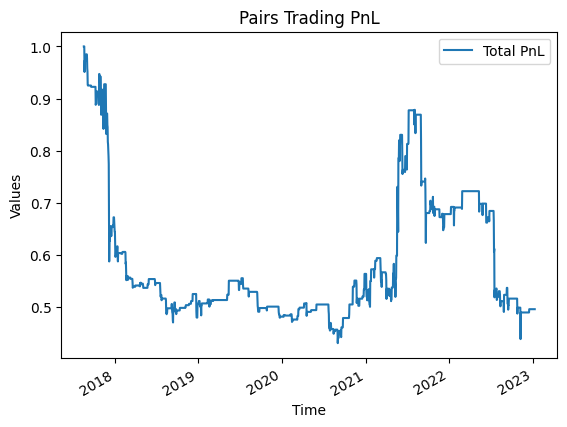

Test PnL


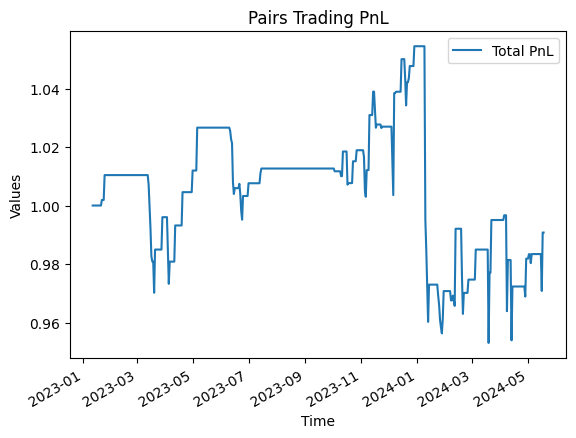

In [8]:
timeframe = "1d"

all_BTC_Day_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Day_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_1, btc_test_1 = train_test_split(
    all_BTC_Day_Data, test_size=0.2, shuffle=False
)

eth_train_1, eth_test_1 = train_test_split(
    all_ETH_Day_Data, test_size=0.2, shuffle=False
)

pair_trade_result(btc_train_1, eth_train_1, btc_test_1, eth_test_1)

Profit vs Entry Levels

C:\Users\wsq\AppData\Local\Temp\ipykernel_47180\1677414132.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_return = btest["Y"][counter] / btest["Y"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_47180\1677414132.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_return = btest["X"][counter] / btest["X"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_47180\1677414132.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

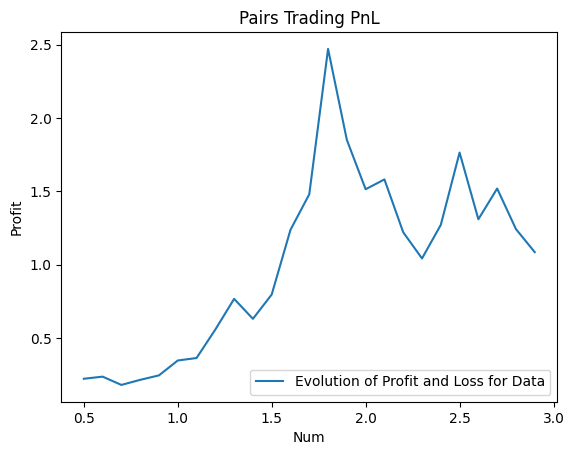

In [40]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_1, eth_train_1, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

Sharpe Ratio vs Entry Levels

C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\163361873.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_return = btest["Y"][counter] / btest["Y"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\163361873.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_return = btest["X"][counter] / btest["X"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_3464\163361873.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

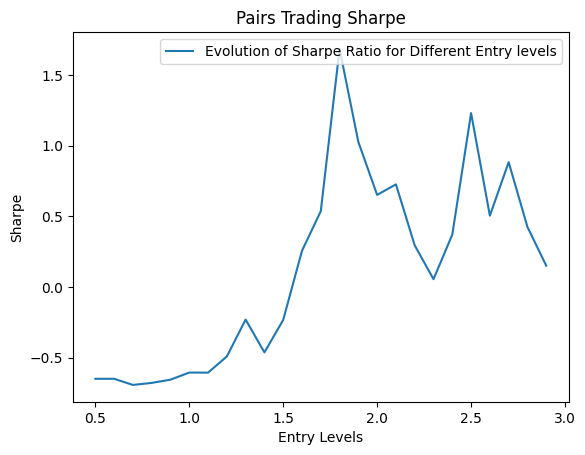

,Sharpe,Std_d
Num,,
2.9,0.151505,0.104253
2.8,0.425363,0.105571
2.7,0.883804,0.108661
2.6,0.504940,0.113439
2.5,1.230547,0.114949
2.4,0.371042,0.135290
2.3,0.055802,0.140111
2.2,0.295044,0.138582
2.1,0.726880,0.147971


In [13]:
final_df = pd.DataFrame(columns=["Num", "Sharpe", "Std_d"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_1, eth_train_1, signal_entry=num) - 1
    profit = profit / len(btc_train_1) * 365
    std_dev = std_dev_returns(btc_train_1, eth_train_1, signal_entry=num) * sqrt(365)
    sharpe = profit / std_dev
    final_df.loc[-1] = [num, sharpe, std_dev]
    final_df.index = final_df.index + 1
    final_df = final_df.sort_index()

final_df.set_index("Num", inplace=True)

final_df["Sharpe"].plot(label="Evolution of Sharpe Ratio for Different Entry levels")
plt.title("Pairs Trading Sharpe")
plt.xlabel("Entry Levels")
plt.ylabel("Sharpe")
plt.legend()
plt.show()

final_df

Trying ETH, BTC hour data

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\3204819033.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\3204819033.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:105: FutureWarning: Series.__getitem__ treating keys as positions is depre

Training PnL


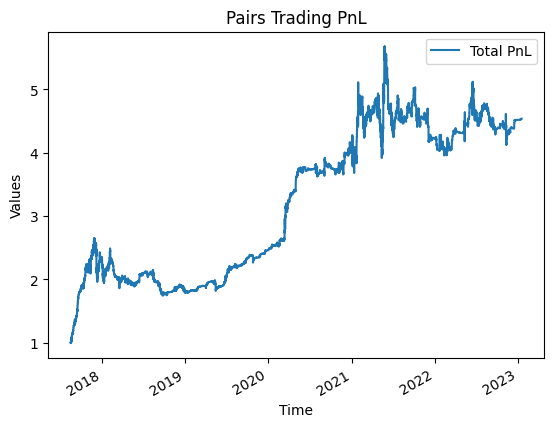

Test PnL


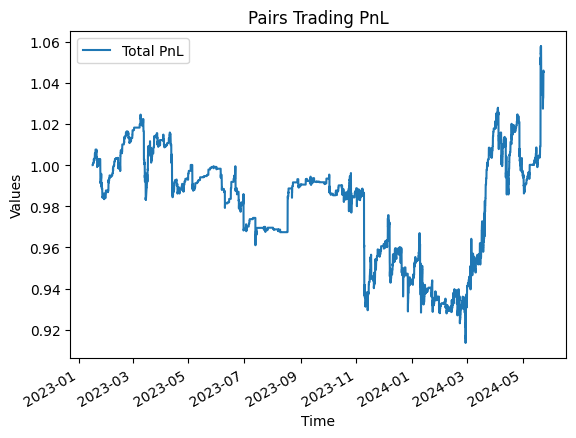

In [6]:
timeframe = "1h"

all_BTC_Day_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Day_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_2, btc_test_2 = train_test_split(
    all_BTC_Day_Data, test_size=0.2, shuffle=False
)

eth_train_2, eth_test_2 = train_test_split(
    all_ETH_Day_Data, test_size=0.2, shuffle=False
)

eth_train_2, eth_test_2

pair_trade_result(btc_train_2, eth_train_2, btc_test_2, eth_test_2)

Profit vs Entry

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_return = btest["Y"][counter] / btest["Y"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_return = btest["X"][counter] / btest["X"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

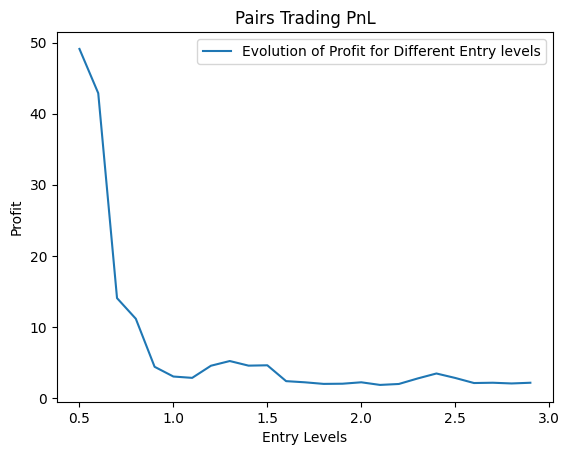

,Profit
Num,
2.9,2.145453
2.8,2.046270
2.7,2.147593
2.6,2.105815
2.5,2.820271
2.4,3.447478
2.3,2.747051
2.2,1.973031
2.1,1.839917


In [26]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_2, eth_train_2, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

final_profits

Sharpe vs Entry

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_return = btest["Y"][counter] / btest["Y"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_return = btest["X"][counter] / btest["X"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

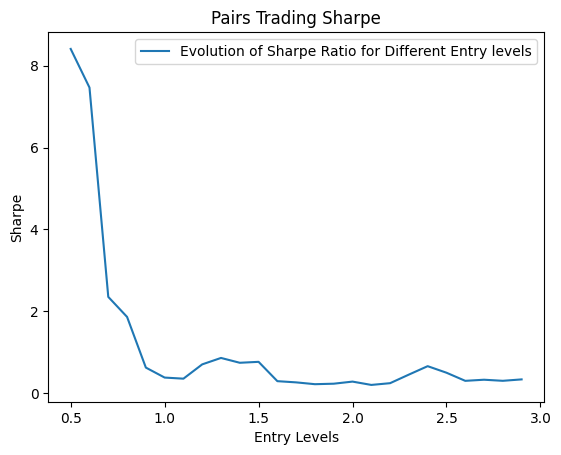

,Sharpe,Std_d
Num,,
2.9,0.340536,0.026337
2.8,0.306054,0.026767
2.7,0.332410,0.027031
2.6,0.305415,0.028349
2.5,0.503684,0.028296
2.4,0.663318,0.028890
2.3,0.457785,0.029881
2.2,0.248058,0.030713
2.1,0.205640,0.031980


In [9]:
final_df = pd.DataFrame(columns=["Num", "Sharpe", "Std_d"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_2, eth_train_2, signal_entry=num) - 1
    profit = profit / len(btc_train_2) * 365
    std_dev = std_dev_returns(btc_train_2, eth_train_2, signal_entry=num) * sqrt(365)
    sharpe = profit / std_dev
    final_df.loc[-1] = [num, sharpe, std_dev]
    final_df.index = final_df.index + 1
    final_df = final_df.sort_index()

final_df.set_index("Num", inplace=True)

final_df["Sharpe"].plot(label="Evolution of Sharpe Ratio for Different Entry levels")
plt.title("Pairs Trading Sharpe")
plt.xlabel("Entry Levels")
plt.ylabel("Sharpe")
plt.legend()
plt.show()

final_df

### Minute Data

Profit vs Entry

In [25]:
eth_train

,Close
2017-08-17 00:00:00,301.13
2017-08-17 00:01:00,301.13
2017-08-17 00:02:00,300.00
2017-08-17 00:03:00,300.00
2017-08-17 00:04:00,301.13
...,...
2022-08-23 06:41:00,1609.49
2022-08-23 06:42:00,1611.36
2022-08-23 06:43:00,1612.11
2022-08-23 06:44:00,1611.53


C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_return = btest["Y"][counter] / btest["Y"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_return = btest["X"][counter] / btest["X"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

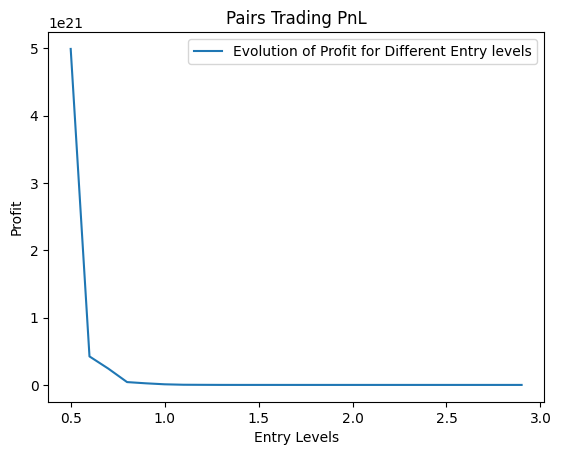

In [21]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train, eth_train, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

In [23]:
final_profits

,Profit
Num,
2.9,5.350399e+11
2.8,1.494089e+12
2.7,2.950277e+12
2.6,4.963715e+12
2.5,1.231974e+13
2.4,2.883596e+13
2.3,6.224063e+13
2.2,1.170545e+14
2.1,2.304648e+14


Sharpe vs Entry

In [22]:
final_df = pd.DataFrame(columns=['Num', 'Sharpe', 'Std_d'])
for num in range(5, 30):
    num = num/10
    profit = final_profit(btc_train, eth_train, signal_entry=num) - 1
    profit = (profit/len(btc_train) * 365)
    std_dev = std_dev_returns(btc_train, eth_train, signal_entry=num) * sqrt(365)
    sharpe = profit/std_dev
    final_df.loc[-1] = [num, sharpe, std_dev]
    final_df.index = final_df.index + 1
    final_df = final_df.sort_index() 

final_df.set_index('Num', inplace=True)

final_df['Sharpe'].plot(label="Evolution of Sharpe Ratio for Different Entry levels")
plt.title("Pairs Trading Sharpe")
plt.xlabel('Entry Levels')
plt.ylabel('Sharpe')
plt.legend()
plt.show()

final_df

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_return = btest["Y"][counter] / btest["Y"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_return = btest["X"][counter] / btest["X"][counter -1] - 1.
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\1926828357.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

KeyboardInterrupt: 